# sparse coding notebook

In [4]:
import numpy as np
import theano 
import theano.tensor as T
import matplotlib.pyplot as plt
import math 
import random 
from scipy.io import loadmat 
from sklearn.feature_extraction.image import PatchExtractor
from collections import OrderedDict
from utils import tile_raster_images as tri
from datasets import gen_bars
%matplotlib inline

In [72]:
class model(object):
    
    #all similarities between noca,mca,sc
    #open sublime through harpo to access mca, sc scripts
    # inslude dim, n_neurons, eps_a, eps_w
    def __init__(self,dim,n_batch,n_neurons,eps_a,eps_w, decay_time,
                 lam, pos_only= True, decay_init=50):
        self.dim = dim
        self.n_batch = n_batch
        self.n_neurons = n_neurons
        self.eps_a = eps_a
        self.eps_w = theano.shared(np.array(eps_w).astype('float32'))
        self.pos_only = pos_only
        self.lam = lam
        self.decay_time = decay_time
        self.decay_init = decay_init
    def reconstruction_cost(self, x, x_hat):
        return (.5*(self.x- x_hat)**2).sum(axis=1).mean()
    def sparsity_cost(self,a):
        return abs(a).sum(axis=1).mean()
    def l0 (self, a):
        return T.neq(self.a,0.).sum(axis=1).mean()
    def costfunction(self, lam, reconstruction_cost, sparsity_cost):
        return reconstruction_cost+ lam*sparsity_cost
    def snr(self, x, x_hat):
        return T.mean(self.x.norm(2,axis=1)**2/(self.x-x_hat).norm(2,axis=1)**2)
    
    def train(self,patches, n_iter=100, epochs=150):
        
        n_batch = self.n_batch
        n_neurons = self.n_neurons
        dim = self.dim

        cost_array = np.zeros((epochs, n_iter))
        recon_array = np.zeros((epochs, n_iter))
        coeff_array = np.zeros((epochs,n_iter))
        l0_array = np.zeros((epochs,n_iter))
        snr_array = np.zeros((epochs, n_iter))
        hist_array = np.zeros((epochs, n_batch, n_neurons))
        im_array = np.zeros((2, epochs, n_batch, dim))
        w_array = np.zeros((epochs, n_neurons, dim))
        
        
        for kk in range(epochs):
            for ii in range(int(math.floor(1.*patches.shape[0]/n_batch))):
                self.initialize()
                self.update_x(patches[ii*n_batch : (ii+1)*n_batch])
                for jj in range(n_iter):
                    cost, recon, coeff, l0, snr, g = self.step_a()
                    #print cost, l0, np.count_nonzero(g), g
                    if ii == 0:
                        cost_array[kk, jj] = cost
                        recon_array[kk, jj] = recon
                        coeff_array[kk, jj] = coeff
                        l0_array[kk, jj] = l0
                        snr_array[kk, jj] = snr
                if kk > self.decay_init:
                     self.decay_eps_w()
                if ii == 0:
                    hist_array[kk] = self.a.get_value()
                    im_array[0, kk] = np.array(self.original())
                    im_array[1, kk] = self.reconstruct()
                    w_array[kk] = self.w.get_value() 
                self.step_w()
                
        model = dict() 
        model['w'] = self.w.get_value()
        model['cost_array'] = cost_array
        model['recon_array'] = recon_array
        model['l0_array'] = l0_array
        model['snr_array'] = snr_array
        model['hist_array'] = hist_array
        model['coeff_array'] = coeff_array
        model['im_array'] = im_array
        model['w_array'] = w_array
        return model 
    
    
class noca(model):
    pass
    
class mca(model):
    
    def setup(self):
        n_batch = self.n_batch
        dim = self.dim
        n_neurons = self.n_neurons
        eps_a = self.eps_a
        eps_w = self.eps_w
        pos_only = self.pos_only
        lam = self.lam
        decay_time = self.decay_time
        p = np.exp(np.log(.1)/decay_time)
            
        self.x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
        w = np.random.rand(n_neurons,dim)
        w_norm = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
        self.w = theano.shared((w/w_norm).astype('float32'))
        self.a = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))
        x_batch = T.matrix() 
        
        x_hat = T.max(self.a.dimshuffle(0,1,'x')*self.w.dimshuffle('x',0,1), axis=1)
        recon = self.reconstruction_cost(self.x, x_hat)
        coeff = self.sparsity_cost(self.a)
        l0 = self.l0(self.a)
        costfunction = self.costfunction(lam, recon, coeff)
        snr = self.snr(self.x, x_hat)
        
        grad_w = T.grad(costfunction, self.w)
        grad_recon_a = T.grad(recon, self.a)
        grad_sparse_a = T.grad(lam*coeff, self.a)

        updates = OrderedDict()
        updates[eps_w] = np.array(p).astype('float32') * eps_w
        self.decay_eps_w = theano.function([], [], updates=updates)
        
        updates = OrderedDict()
        
        t = theano.shared(np.array(1.).astype('float32'))
        a_old = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))

        a_prime = self.a - eps_a * grad_recon_a
        abs_a = abs(a_prime) - lam*eps_a
        a_ista = T.sgn(a_prime) * T.nnet.relu(abs_a)

        t1 = 0.5 * (1 + T.sqrt(1. + 4. * t ** 2))
        a_new = a_ista + (t1 - 1.) / t * (a_ista - a_old)
        
        if self.pos_only:
            updates[self.a] = T.nnet.relu(a_new)
            updates[a_old] = T.nnet.relu(a_ista)
        else:
            updates[self.a] = a_new
            updates[a_old] = a_ista
        
        self.step_a = theano.function([], [costfunction,
                                              recon, coeff, l0, snr, grad_recon_a],
                                         updates=updates)
        updates[self.a] = 0.*self.a 
        updates[a_old] = 0. *a_old
        updates[t] = 1.
        
        self.initialize = theano.function([],[],updates = updates)

        updates = OrderedDict()
        updates[self.x] = x_batch
        self.update_x = theano.function([x_batch],[],updates = updates)

        updates = OrderedDict()
        wp = self.w - eps_w*grad_w
        wp_norm = T.sqrt(T.sum(self.w**2, axis=1, keepdims=True))
        updates[self.w] = wp/wp_norm
        
        self.step_w = theano.function([],[costfunction],updates = updates)
        
        self.reconstruct = theano.function([],x_hat)
        self.original = theano.function([], self.x)
        
        
    
class sc(model):
    
    def setup(self):
        n_batch = self.n_batch
        dim = self.dim
        n_neurons = self.n_neurons
        eps_a = self.eps_a
        eps_w = self.eps_w
        pos_only = self.pos_only
        lam = self.lam
        decay_time = self.decay_time
        p = np.exp(np.log(.1)/decay_time)

        self.x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
        w = np.random.rand(n_neurons,dim)
        w_norm = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
        self.w = theano.shared((w/w_norm).astype('float32'))
        self.a = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))
        x_batch = T.matrix() 

        x_hat = T.dot(self.a,self.w)
        recon = self.reconstruction_cost(self.x, x_hat)
        coeff = self.sparsity_cost(self.a)
        l0 = self.l0(self.a)
        costfunction = self.costfunction(lam, recon, coeff)
        snr = self.snr(self.x, x_hat)
        
        x_hat = x_hat
        costfunction = costfunction
        snr = snr
        
        grad_w = T.grad(costfunction,self.w)
        grad_recon_a = T.grad(recon,self.a)
        grad_sparse_a = T.grad(lam*coeff, self.a)

        updates = OrderedDict()
        updates[eps_w] = np.array(p).astype('float32') * eps_w
        self.decay_eps_w = theano.function([], [], updates=updates)

        updates = OrderedDict()
        
        t = theano.shared(np.array(1.).astype('float32'))
        a_old = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))

        a_prime = self.a - eps_a * grad_recon_a
        abs_a = abs(a_prime) - lam*eps_a
        a_ista = T.sgn(a_prime) * T.nnet.relu(abs_a)

        t1 = 0.5 * (1 + T.sqrt(1. + 4. * t ** 2))
        a_new = a_ista + (t1 - 1.) / t * (a_ista - a_old)
        
        if self.pos_only:
            updates[self.a] = T.nnet.relu(a_new) 
            updates[a_old] = T.nnet.relu(a_ista)
        else:
            updates[a] = a_new
            updates[a_old] = a_ista
            
        self.step_a = theano.function([], [costfunction,
                                              recon, coeff, l0, snr, grad_recon_a],
                                         updates=updates)
            
        updates[self.a] = 0.*self.a 
        updates[a_old] = 0. *a_old
        updates[t] = 1.
        
        self.initialize = theano.function([],[],updates=updates)
        
        updates = OrderedDict()
        updates[self.x] = x_batch
        self.update_x = theano.function([x_batch],[],updates=updates)

        updates = OrderedDict()
        wp = self.w - eps_w*grad_w
        wp_norm = T.sqrt(T.sum(self.w**2, axis=1, keepdims=True))
        updates[self.w] = wp/wp_norm
        
        self.step_w = theano.function([],[costfunction],updates=updates)
        
        self.reconstruct = theano.function([],x_hat)
        self.original = theano.function([], self.x)


# Identity

In [73]:
my_model = sc(dim=10,n_batch=10,n_neurons=10,eps_a=.1,eps_w=.1,decay_time=5000000,
                 lam=.01)
patches = np.eye(10, dtype='float32')

In [74]:
my_model = mca(dim=10,n_batch=10,n_neurons=10,eps_a=.1,eps_w=.1,decay_time=5000000,
                 lam=.01)
patches = np.eye(10, dtype='float32')

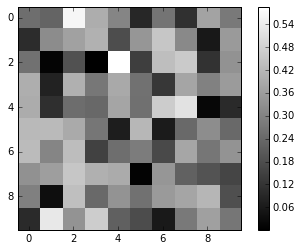

In [75]:
my_model.setup()
plt.imshow(my_model.w.get_value(), cmap='gray', interpolation='nearest')
plt.colorbar()

In [76]:
d = my_model.train(patches, epochs=5000)

[ 1.00267541  1.00267541  1.00267541  1.00267541  1.00267541  1.00267541
  1.00267541  1.00267541  1.00267541  1.00267541]


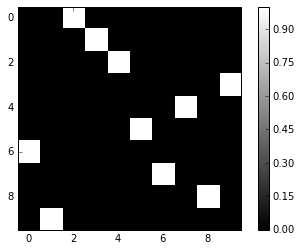

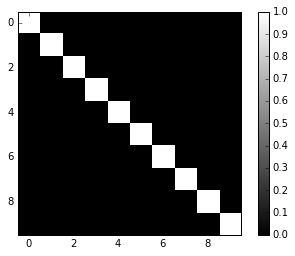

In [77]:
print (d['w']**2).sum(axis=1)
plt.imshow(d['w'], cmap='gray', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(patches, cmap='gray', interpolation='nearest')
plt.colorbar()

# Bars

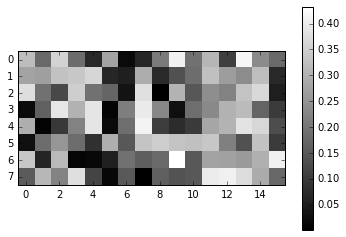

In [89]:
n_ims = 200
my_model = mca(dim=16,n_batch=n_ims,n_neurons=8,eps_a=.1,eps_w=.1,decay_time=10000000,
                 lam=.001)
patches, barcolors = gen_bars(n_ims, bw=True)
patches = patches.reshape(n_ims,-1).astype('float32')
my_model.setup()
plt.imshow(my_model.w.get_value(), cmap='gray', interpolation='nearest')
plt.colorbar()



In [90]:
d = my_model.train(patches, epochs=500)

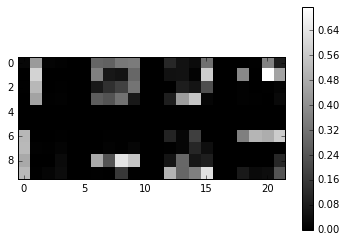

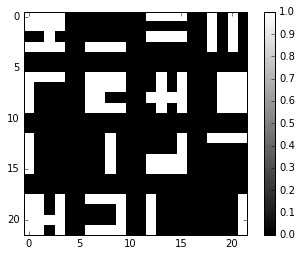

In [91]:
ims=tri(d['w'], (4,4), (2,4), (2,2), scale_rows_to_unit_interval=False, output_pixel_vals=False)
plt.imshow(ims, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.figure()
ims=tri(patches, (4,4), (4,4), (2,2), scale_rows_to_unit_interval=False, output_pixel_vals=False)
plt.imshow(ims, cmap='gray', interpolation='nearest')
plt.colorbar()

In [92]:
d['w'].max()

0.71566397